In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import re
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.layers import Input, Flatten, Activation, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [42]:
height, width, depth = 96, 96, 3
save_path = 'python/first_model.model'

In [43]:
def load_dataset(path, height, width, least_num):
    image_list, label_list = [], []
    for root, dirs, files in os.walk(path):
        temp_images, temp_labels = [], []
        for file in files:
            try:
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (height, width))
                temp_images.append(image)
                temp_labels.append(root.split('\\')[1])
            except:
                continue
        if len(temp_images)>= least_num:
            image_list.extend(temp_images)
            label_list.extend(temp_labels)
            
    num_classes = len(np.unique(label_list))
    # num_classes = 1
    
    return image_list, label_list, num_classes

In [44]:
def get_model(height, weight, depth, num_classes):
    K.clear_session()
    
    X_input = Input((height, width, depth))
    
    X = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(X_input)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2), strides = (2,2))(X)
    
    X = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2), strides = (2,2))(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2), strides = (2,2))(X)
    X = Dropout(0.3)(X)
    
    X = Flatten()(X)
    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(32)(X)
    
    X = Dense(num_classes, activation = 'softmax')(X)
    
    model = Model(inputs = X_input, outputs = X)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    
    return model

In [45]:
def train_model(model, epochs, save_path, train_X, train_y, test_X, test_y, data_augmentation = False):
    batch_size = 32
    early_stopping = EarlyStopping(patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(save_path, save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
    
    if data_augmentation:
        datagen = ImageDataGenerator(
            rescale=1/255.,
            featurewise_center=False, # Set input mean to 0 over the dataset, feature-wise.
            samplewise_center=False, # Set each sample mean to 0.
            featurewise_std_normalization=False, # Divide inputs by std of the dataset, feature-wise.
            samplewise_std_normalization=False, # Divide each input by its std.
            zca_whitening=False, # Apply ZCA whitening.
            rotation_range=15, # Degree range for random rotations.
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False)

    else:
        datagen = ImageDataGenerator(
            rescale=1/255)
    
    history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size), 
                                  steps_per_epoch=len(train_X) / batch_size,
                                  validation_data=datagen.flow(test_X, test_y, batch_size=batch_size),
                                  validation_steps=len(test_X) / batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks)
    
    return model, history

In [46]:
image_list, label_list, num_classes = load_dataset('/Users/User/Downloads/archive/pizza_not_pizza', height, width, 300)

In [47]:
le = LabelEncoder()
label_list = le.fit_transform(label_list)

np.save('classes.npy', le.classes_)

In [48]:
train_X, test_X, train_y, test_y = train_test_split(np.array(image_list), label_list, test_size = 0.2, stratify = label_list)

In [49]:
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

In [50]:
model = get_model(height, width, depth, num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128   

In [51]:
model, history = train_model(model, 200, save_path, train_X, train_y, test_X, test_y, data_augmentation = False)

Epoch 1/200


C:\Users\User\AppData\Local\Temp\ipykernel_1196\2504467667.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size),


50/49 [==============================] - ETA: -1s - loss: 0.5975 - accuracy: 0.7093
Epoch 1: val_loss improved from inf to 1.19685, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 73s 1s/step - loss: 0.5975 - accuracy: 0.7093 - val_loss: 1.1969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
50/49 [==============================] - ETA: -1s - loss: 0.4733 - accuracy: 0.7888
Epoch 2: val_loss improved from 1.19685 to 0.71718, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 75s 2s/step - loss: 0.4733 - accuracy: 0.7888 - val_loss: 0.7172 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 3/200
50/49 [==============================] - ETA: -1s - loss: 0.4264 - accuracy: 0.8060
Epoch 3: val_loss did not improve from 0.71718
49/49 [==============================] - 72s 1s/step - loss: 0.4264 - accuracy: 0.8060 - val_loss: 1.3563 - val_accuracy: 0.5076 - lr: 0.0010
Epoch 4/200
50/49 [==============================] - ETA: -1s - loss: 0.3044 - accuracy: 0.8779
Epoch 4: val_loss improved from 0.71718 to 0.67205, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 74s 2s/step - loss: 0.3044 - accuracy: 0.8779 - val_loss: 0.6720 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 5/200
50/49 [==============================] - ETA: -1s - loss: 0.2165 - accuracy: 0.9179
Epoch 5: val_loss did not improve from 0.67205
49/49 [==============================] - 71s 1s/step - loss: 0.2165 - accuracy: 0.9179 - val_loss: 0.6763 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 6/200
50/49 [==============================] - ETA: -1s - loss: 0.1486 - accuracy: 0.9504
Epoch 6: val_loss did not improve from 0.67205
49/49 [==============================] - 71s 1s/step - loss: 0.1486 - accuracy: 0.9504 - val_loss: 0.7154 - val_accuracy: 0.6574 - lr: 0.0010
Epoch 7/200
50/49 [==============================] - ETA: -1s - loss: 0.1123 - accuracy: 0.9625
Epoch 7: val_loss did not improve from 0.67205
49/49 [==============================] - 71s 1s/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 0.7560 - val_accuracy: 0.7234 - lr: 0.0010
Epo

INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 75s 2s/step - loss: 0.1349 - accuracy: 0.9510 - val_loss: 0.6191 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 9/200
50/49 [==============================] - ETA: -1s - loss: 0.0607 - accuracy: 0.9816
Epoch 9: val_loss did not improve from 0.61911
49/49 [==============================] - 76s 2s/step - loss: 0.0607 - accuracy: 0.9816 - val_loss: 0.6684 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 10/200
50/49 [==============================] - ETA: -1s - loss: 0.0391 - accuracy: 0.9885
Epoch 10: val_loss did not improve from 0.61911
49/49 [==============================] - 72s 1s/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.7011 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 11/200
50/49 [==============================] - ETA: -1s - loss: 0.0773 - accuracy: 0.9720
Epoch 11: val_loss did not improve from 0.61911
49/49 [==============================] - 72s 1s/step - loss: 0.0773 - accuracy: 0.9720 - val_loss: 0.7429 - val_accuracy: 0.7487 - lr: 0.0010

INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 74s 2s/step - loss: 0.0392 - accuracy: 0.9885 - val_loss: 0.5915 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 13/200
50/49 [==============================] - ETA: -1s - loss: 0.0186 - accuracy: 0.9949
Epoch 13: val_loss did not improve from 0.59152
49/49 [==============================] - 73s 1s/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.8570 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 14/200
50/49 [==============================] - ETA: -1s - loss: 0.0288 - accuracy: 0.9905
Epoch 14: val_loss did not improve from 0.59152
49/49 [==============================] - 75s 2s/step - loss: 0.0288 - accuracy: 0.9905 - val_loss: 0.8670 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 15/200
50/49 [==============================] - ETA: -1s - loss: 0.0520 - accuracy: 0.9752
Epoch 15: val_loss did not improve from 0.59152
49/49 [==============================] - 74s 2s/step - loss: 0.0520 - accuracy: 0.9752 - val_loss: 1.6412 - val_accuracy: 0.6624 - lr: 0.00

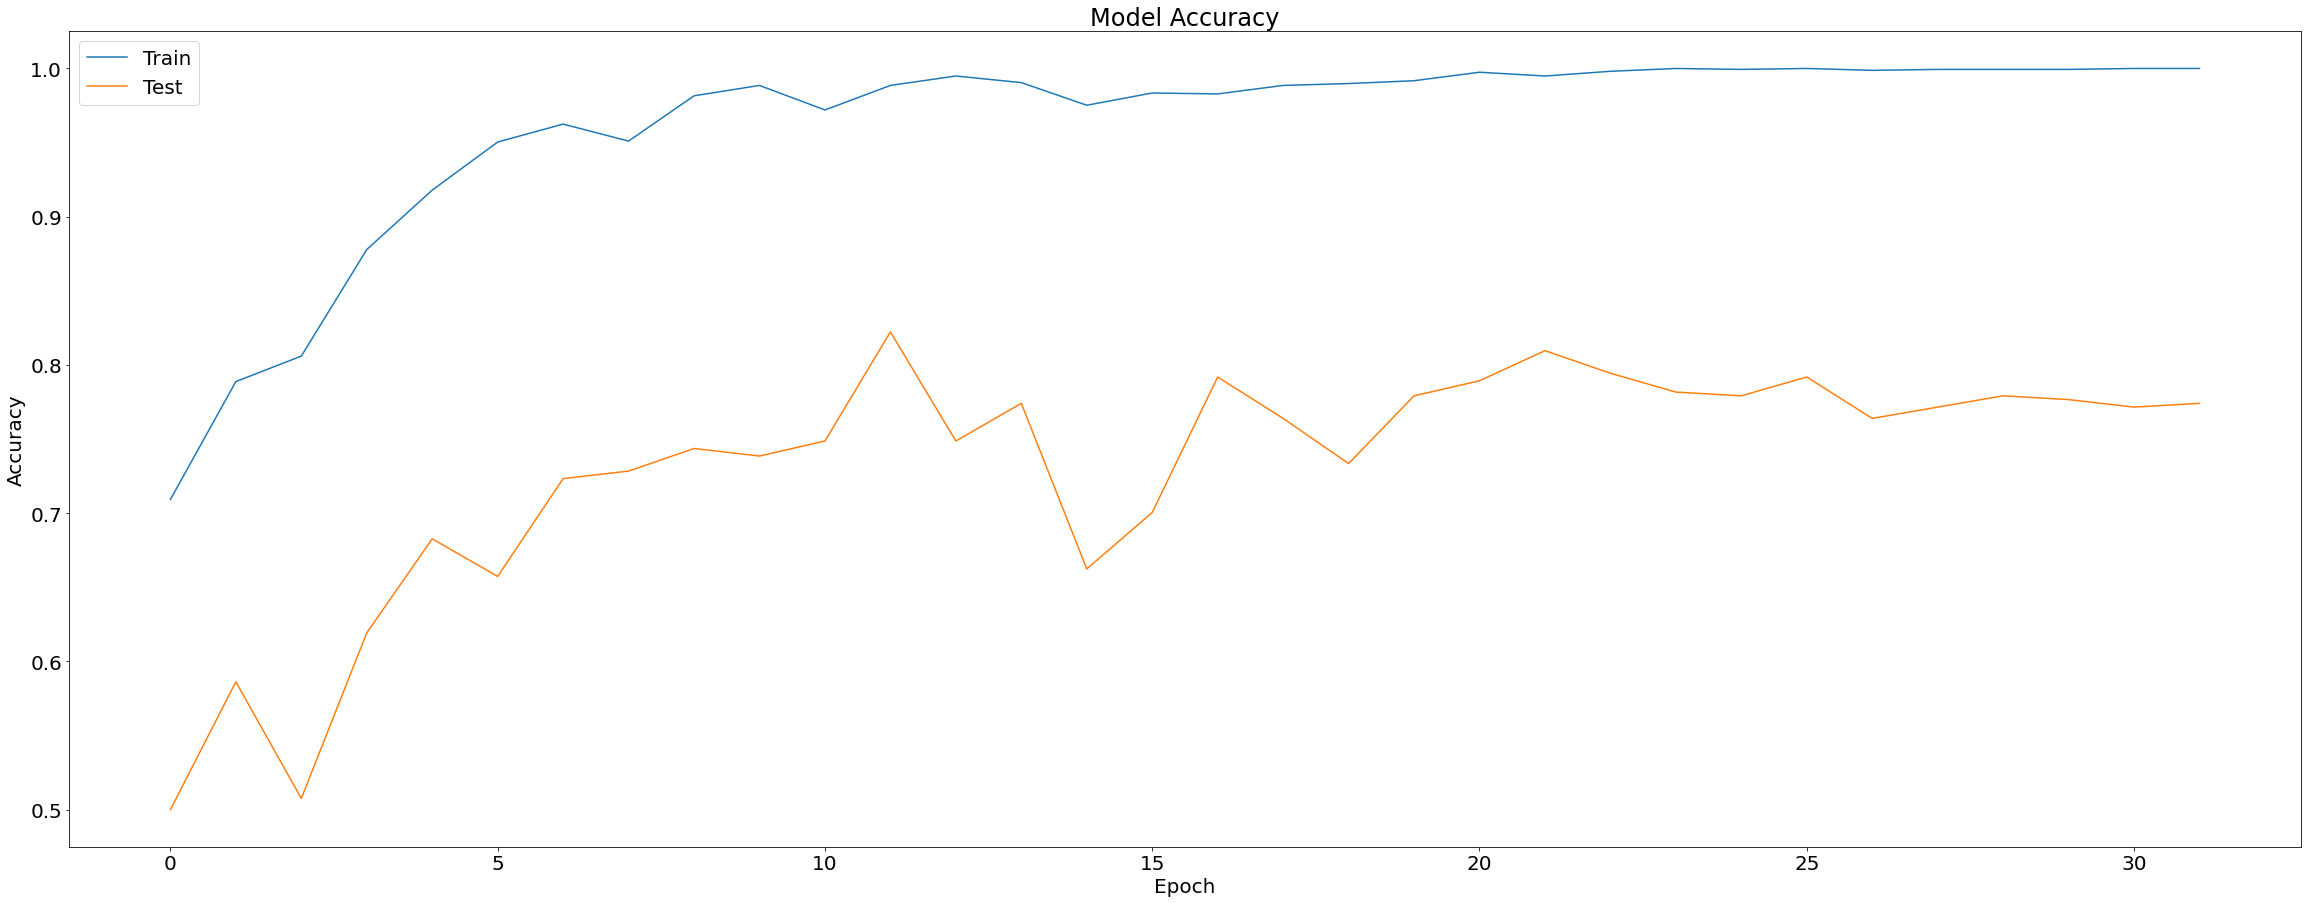

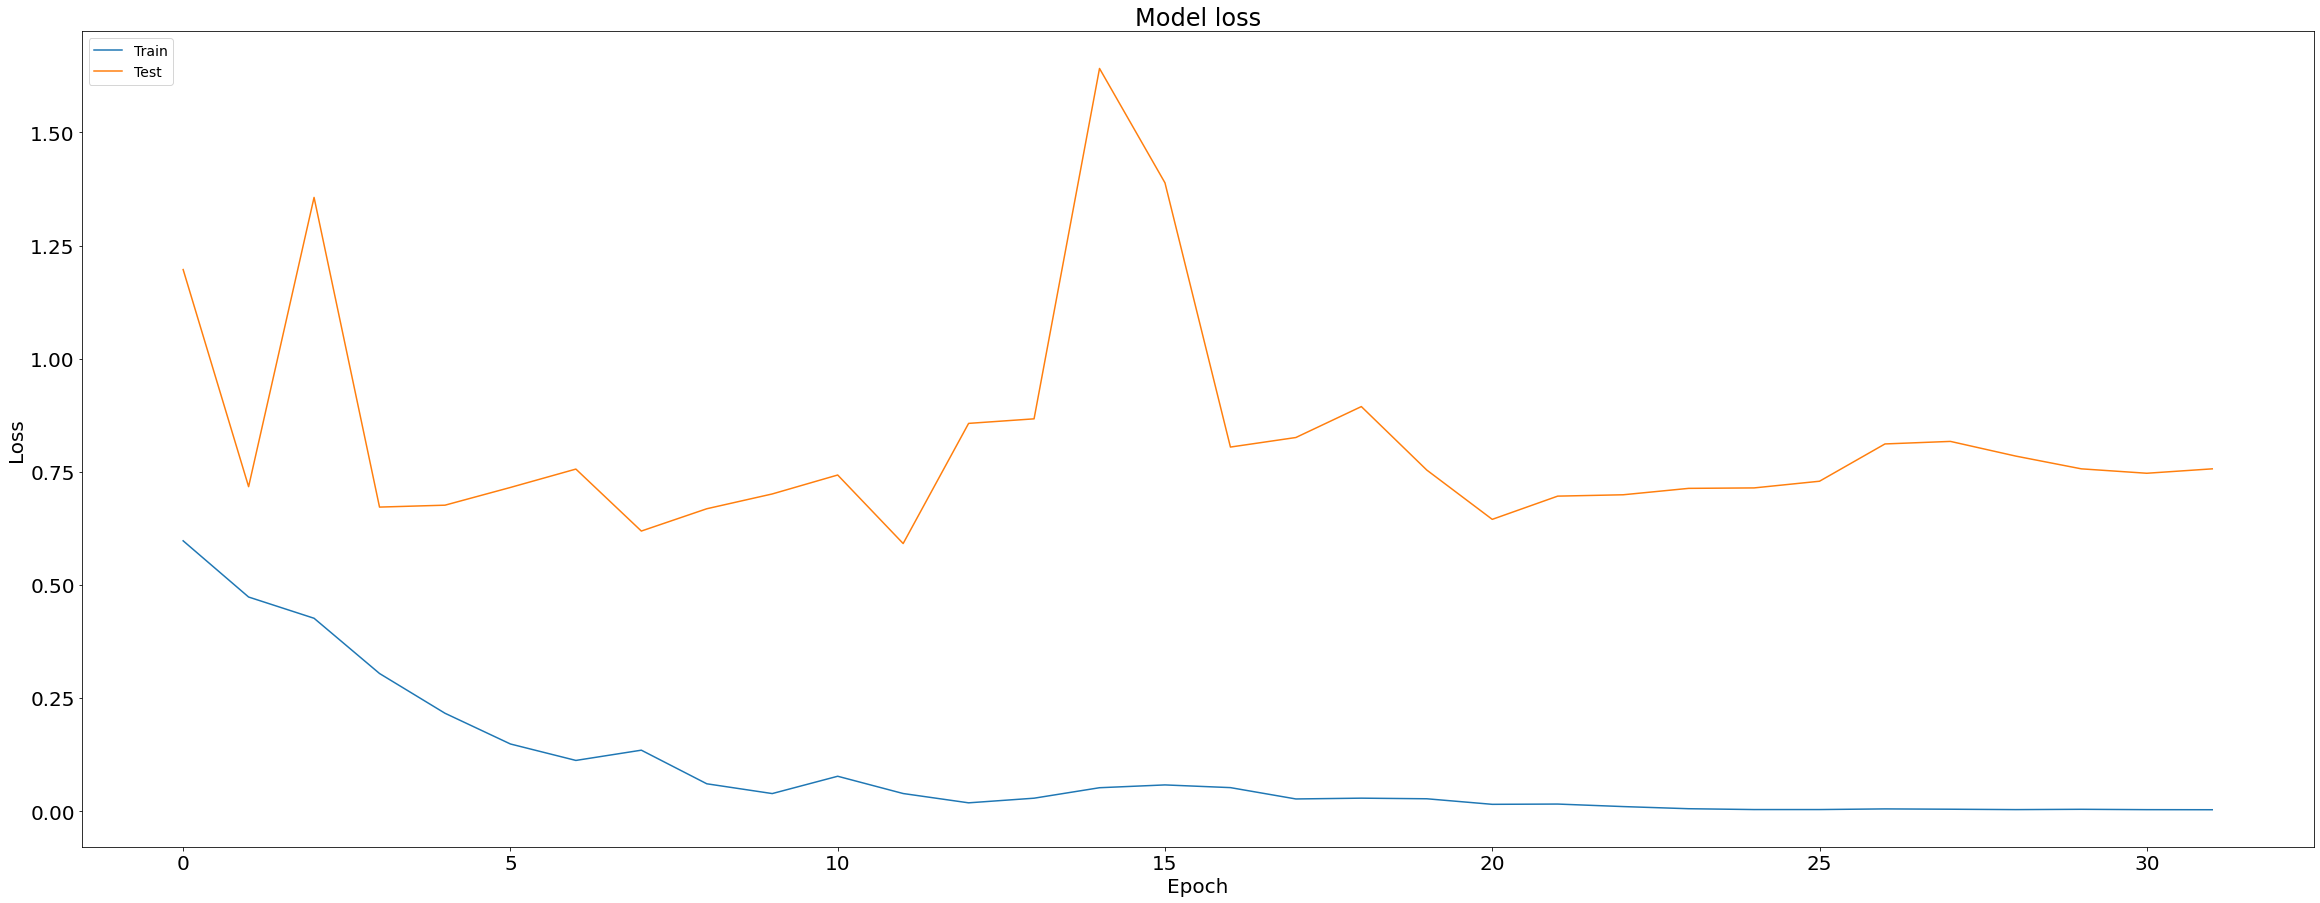

In [55]:
plt.figure(figsize = (40,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 20)
plt.show()

plt.figure(figsize = (40,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 14)
plt.show()

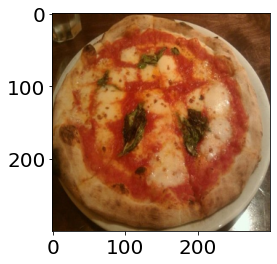

1/1 [==============================] - 0s 69ms/step
[[1.4614459e-06 9.9999857e-01]]
1


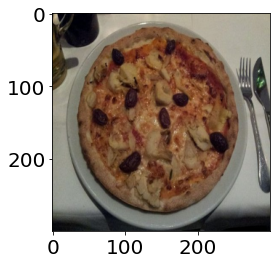

1/1 [==============================] - 0s 23ms/step
[[5.3134609e-06 9.9999464e-01]]
1


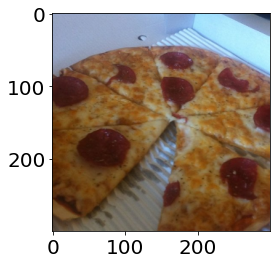

1/1 [==============================] - 0s 38ms/step
[[2.2385306e-04 9.9977618e-01]]
1


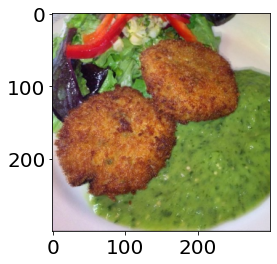

1/1 [==============================] - 0s 26ms/step
[[9.9998462e-01 1.5339398e-05]]
0


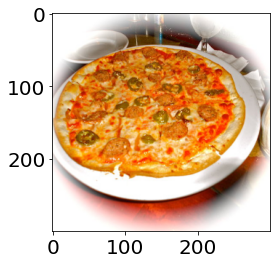

1/1 [==============================] - 0s 34ms/step
[[1.5414774e-11 1.0000000e+00]]
1


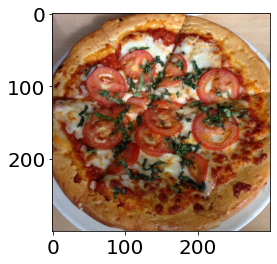

1/1 [==============================] - 0s 30ms/step
[[1.217621e-06 9.999988e-01]]
1


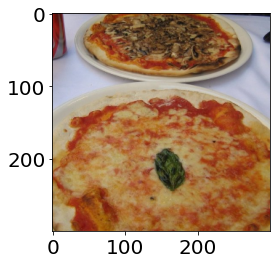

1/1 [==============================] - 0s 33ms/step
[[1.6179661e-09 1.0000000e+00]]
1


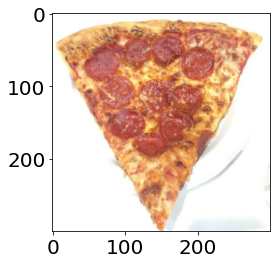

1/1 [==============================] - 0s 27ms/step
[[1.4912367e-13 1.0000000e+00]]
1


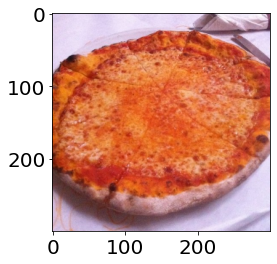

1/1 [==============================] - 0s 25ms/step
[[1.0330442e-09 1.0000000e+00]]
1


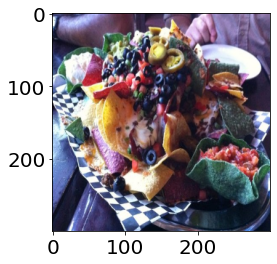

1/1 [==============================] - 0s 36ms/step
[[9.9999726e-01 2.6892274e-06]]
0


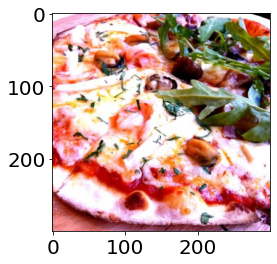

1/1 [==============================] - 0s 26ms/step
[[2.0019415e-17 1.0000000e+00]]
1


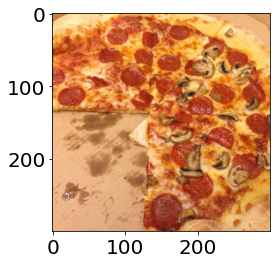

1/1 [==============================] - 0s 32ms/step
[[7.83814e-12 1.00000e+00]]
1


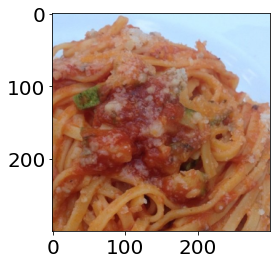

1/1 [==============================] - 0s 32ms/step
[[9.9999964e-01 3.5689112e-07]]
0


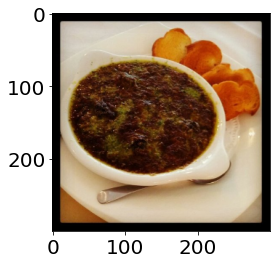

1/1 [==============================] - 0s 24ms/step
[[9.9999464e-01 5.3284562e-06]]
0


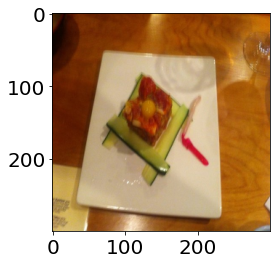

1/1 [==============================] - 0s 28ms/step
[[9.9999642e-01 3.6288254e-06]]
0


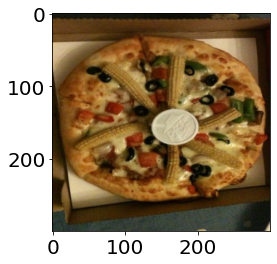

1/1 [==============================] - 0s 33ms/step
[[3.5098758e-08 1.0000000e+00]]
1


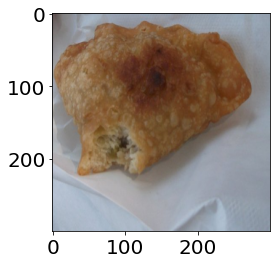

1/1 [==============================] - 0s 43ms/step
[[9.9999750e-01 2.5598515e-06]]
0


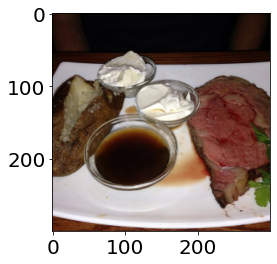

1/1 [==============================] - 0s 32ms/step
[[1.0000000e+00 2.0681632e-09]]
0


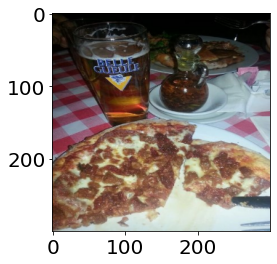

1/1 [==============================] - 0s 29ms/step
[[9.223084e-09 1.000000e+00]]
1


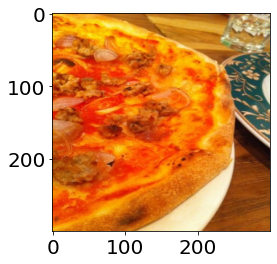

1/1 [==============================] - 0s 26ms/step
[[2.1692958e-15 1.0000000e+00]]
1


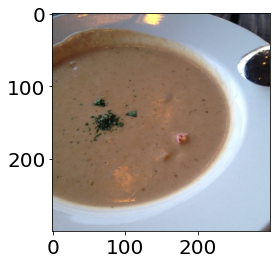

1/1 [==============================] - 0s 27ms/step
[[9.9998879e-01 1.1169417e-05]]
0


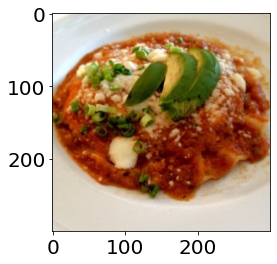

1/1 [==============================] - 0s 24ms/step
[[1.0000000e+00 5.9977414e-09]]
0


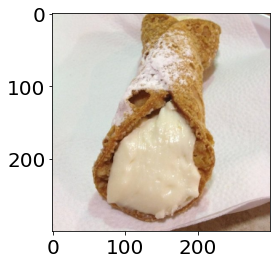

1/1 [==============================] - 0s 28ms/step
[[0.99381953 0.0061805 ]]
0


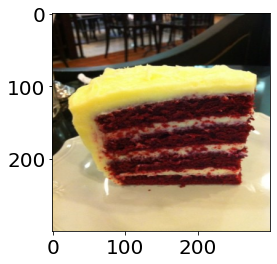

1/1 [==============================] - 0s 23ms/step
[[1.0000000e+00 1.7221509e-10]]
0


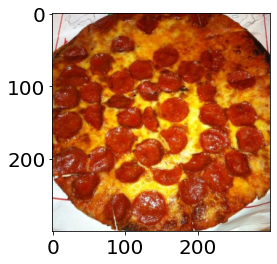

1/1 [==============================] - 0s 28ms/step
[[6.9078255e-06 9.9999309e-01]]
1


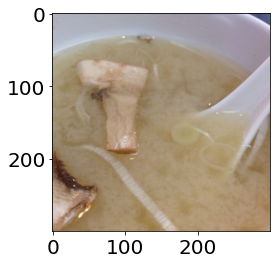

1/1 [==============================] - 0s 34ms/step
[[9.9999917e-01 8.4766810e-07]]
0


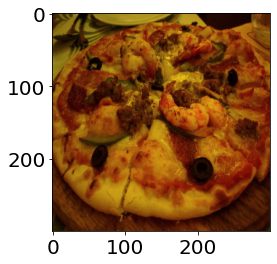

1/1 [==============================] - 0s 22ms/step
[[8.1057253e-05 9.9991894e-01]]
1


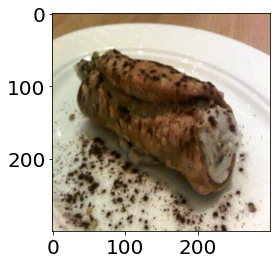

1/1 [==============================] - 0s 21ms/step
[[1.00000e+00 8.86028e-10]]
0


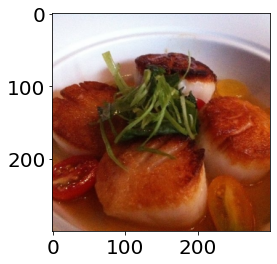

1/1 [==============================] - 0s 25ms/step
[[9.9988461e-01 1.1541991e-04]]
0


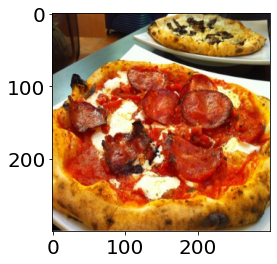

1/1 [==============================] - 0s 24ms/step
[[1.7137829e-09 1.0000000e+00]]
1


In [58]:
# plt.figure(figsize = (96,96))
# image = cv2.imread(image)

for _ in range(30):
    
    i = random.randint(0, len(image_list))

    img_rgb = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    pred_train = model.predict(np.expand_dims(image_list[i] / 255., axis=0))
    print(pred_train)
    print(label_list[i])